# Lab 9:  PCA for Movie Recommendations

A common application of PCA is for recommendation systems.  In this lab, we will use PCA to create a very primitive recommendation system for movies.  Through the lab, you will learn to:
* Represent ratings data as a sparse matrix
* Perform PCA on the rating matrix to find reccomendations
* Interpret PCA loadings of rating data

## Loading the MovieLens Dataset

We first load some common packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[GroupLens](https://grouplens.org/) is a research organization at the University of Minnesota that has done extensive work in recommendation systems among other topics.  They have excellent datasets on movie recommendations as part of their [MovieLens project](https://movielens.org/).  In this lab, we will use a very small dataset that is useful for illustrating basic ideas.  But, if you are interested in continuing research in this area, they have much larger datasets.

To get the data, go to the webpage:

https://grouplens.org/datasets/movielens/latest/

and download and unzip the files, `ml-data-small.zip`.  

Once, the data is downloaded, use the `pd.read_csv` command to load the `movies.csv` file and store the results in a pandas dataframe `movies`. The `movies` dataframe will have the title and genres of the movies that are to be rated.    Use the `head` method to print the first 5 rows of the `movies` dataframe.  

In [2]:
movies = pd.read_csv('movies.csv')

Extract the following columns from the `movies` dataframe:
*  Extract the `movieId` column, convert to an `np.array` and store in `movie_ids`
*  Extract the `title` column, convert to a list (using `.tolist()`) and store in `titles`

In [3]:
movie_ids = np.array(movies['movieId'])
titles = movies['title'].tolist()

The following function returns the string of a movie title, given its movie id.

In [4]:
def get_movie_title(movie_id):
    I = np.where(movie_ids == movie_id)[0]
    if len(I) == 0:
        return 'unknown'
    else:
        return titles[I[0]]

Load the `ratings.csv` file into a `pandas` dataframe `ratings`.  Use the `head` method to print the first five rows of the dataframe.

In [5]:
ratings = pd.read_csv('ratings.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Extract three columns from the `ratings` dataframe: `user_ids`, `user_movies` and `user_ratings` with the user id, movie id and rating score  Convert to each to an `np.array`.

## Create a Ratings Matrix

We now create a ratings matrix from the ratings using the `pivot_table` commmand as follows.  

In [6]:
M = ratings.pivot_table(index=['userId'], columns=['movieId'], values='rating')
movie_col = M.columns.tolist()
user_row = M.index.tolist()

Display the data frame using the `M.head()` command.

In [7]:
M.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You shoul see that most of the entries are `NaN` since most of the movies were not rated.  A key challenge in recommendation systems is to fill these in.  

For this lab, use the `fillna` command to fill in all the `NaN` entries with zeros.  Store the filled in dataframe in `Mfill`.  Print the first few rows of the new dataframe.

Filling in with zeros is not the best idea, but it is simple and will be OK for this lab.  But, real recommendation do something more sophisticated called *matrix completion*.

In [8]:
Mfill =M.fillna(0)

Convert `Mfill` to an `np.array`.

In [9]:
Mfill=np.array(Mfill)

Using the shape of `Mfill`, find the number of users and movies and print the results.

In [10]:
print('number of users:',Mfill.shape[0])
print('number of movies:',Mfill.shape[1])

number of users: 671
number of movies: 9066


## Take a PCA of the Ratings Matrix

We now take a PCA of the traings matrix.  First, create a matrix `X` formed by standardizing the matrix `Mfill`.  That is, subtract the mean and divide by the standard deviation of each column of `Mfill`.

In [11]:
Mmean = np.mean(Mfill,axis=0)
Mstd = np.std(Mfill, axis=0)
X = (Mfill-Mmean[None,:])/Mstd[None,:]

Now, take an SVD of X to perform the PCA.  Use the `np.linalg.svd` method with `full_matrices=False`.  Due to the size of the matrix, this make take a minute or so.

In [12]:
U,S,Vt = np.linalg.svd(X, full_matrices=False)

Plot the portion of variance as a function of the number of PCs.  In this example, you will see that the data is not that low rank.  This arises since we have filled in many entries with their mean values.

Text(0,0.5,'PoV')

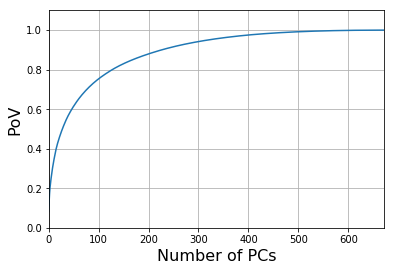

In [13]:
lam = S**2
PoV = np.cumsum(lam)/np.sum(lam)

plt.plot(PoV)
plt.grid()
plt.axis([1,X.shape[0],0, 1.1])
plt.xlabel('Number of PCs', fontsize=16)
plt.ylabel('PoV', fontsize=16)

## Making a Recommendation
We can now use our PCA to make recommendations.  First, create a matrix `Xest` by taking a rank `r=50` approximation of the original matrix `X`.

In [14]:
r = 50
Xest = (U[:,:r]*S[None,:r]).dot(Vt[:r,:])

Now, using the mean and standard deviation from the above, compute `Mest`, the corresponding low-rank approximation of the `Mred`.

In [15]:
Mest = Xest*Mstd[None,:]+Mmean[None,:]

Now, take some row of the estimated rating matrix, say the row with index, `ind=10`.  The predicted ratings for that user will be in `Mest[ind,:]`.  Find the 20 indices `j` where `Mest[ind,j]` is the largest.  For each `j`, print:
* movie title 
* the predicted rating `Mest[ind,j]`
* the actual rating `Mfill[ind,j]`

Note that you must use  `movie_col` and `get_movie_title()` to find the movie title. 

You will notice that the predicted rating is very low.  This is because we filled in the unknown entries with zeros.  But, you should see that the values of `Mest` that are large correspond to movies that the user rated well (4 or 5).

In [16]:
ind = 10   # Row index
ntop = 20  # Print the ntop movie recommendations

topr = np.argsort(Mest[ind,:])[-ntop:]
for j in topr[::-1]:
    print(get_movie_title(movie_col[j])) 
    print('pred rating:', Mest[ind,j], 'actual raiting:',Mfill[ind,j],'\n')

Shawshank Redemption, The (1994)
pred rating: 1.60365160376 actual raiting: 0.0 

Pulp Fiction (1994)
pred rating: 1.52150028029 actual raiting: 5.0 

Forrest Gump (1994)
pred rating: 1.51806603992 actual raiting: 0.0 

Silence of the Lambs, The (1991)
pred rating: 1.29795618168 actual raiting: 0.0 

Star Wars: Episode IV - A New Hope (1977)
pred rating: 1.2539933048 actual raiting: 0.0 

Matrix, The (1999)
pred rating: 1.13593446461 actual raiting: 0.0 

Schindler's List (1993)
pred rating: 1.01404958092 actual raiting: 0.0 

Fight Club (1999)
pred rating: 0.959954699004 actual raiting: 0.0 

Jurassic Park (1993)
pred rating: 0.955836470605 actual raiting: 0.0 

Dark Knight, The (2008)
pred rating: 0.937898077298 actual raiting: 0.0 

Toy Story (1995)
pred rating: 0.937703347353 actual raiting: 0.0 

Fargo (1996)
pred rating: 0.914210459312 actual raiting: 0.0 

Godfather, The (1972)
pred rating: 0.890318446535 actual raiting: 0.0 

Star Wars: Episode V - The Empire Strikes Back (1980

To evaluate if these are *good ratings*, we could split the data into training and test.  Then, we would fit the PCA on the training data, and then compare the predicted ratings on the test data.  But, we won't do this here.

## Interpreting the PCs

It is useful to examine the principal components to see which movies figure prominently in each component.  Recall that the `i-th` PC is in the vector, `Vt[i,:]`.  For the top `npc=4` principal components, find the indices `j` where `Vt[i,j]` has the largest absolute value and print the corresponding movie titles.  

Ideally, each PC would correspond to some aspect of the movies and hence the movies with the highest loading values in the same PC will have some common aspect.  Since we did a very simple completion, we may not see such a grouping here.

In [17]:
npc = 4
ntop = 5
for i in range(npc):
    print("For PC",i,"The top rating movies are:")
    topc = np.argsort(abs(Vt[i,:]))[-ntop:]
    for j in topc[::-1]:
        print(get_movie_title(movie_col[j])) 
    print('\n')

For PC 0 The top rating movies are:
Wasp Woman, The (1959)
Groove Tube, The (1974)
Hard Way, The (1943)
They Live by Night (1949)
Last Wave, The (1977)


For PC 1 The top rating movies are:
Muppets Most Wanted (2014)
Hello Ladies: The Movie (2014)
Romantics, The (2010)
Rum Diary, The (2011)
The Longest Week (2014)


For PC 2 The top rating movies are:
H.O.T.S. (1979)
Carnosaur 2 (1995)
Catwalk (1996)
Mute Witness (1994)
Frankie Starlight (1995)


For PC 3 The top rating movies are:
Above the Rim (1994)
Dragon Ball Z: Bardock - The Father of Goku (Doragon bôru Z: Tatta hitori no saishuu kessen - Furiiza ni itonda Z senshi Kakarotto no chichi) (1990)
Dragon Ball Z: Cooler's Revenge (Doragon bôru Z 5: Tobikkiri no saikyô tai saikyô) (1991)
Stranger Things
Dragon Ball Z: Broly - The Legendary Super Saiyan (Doragon bôru Z 8: Moetsukiro!! Nessen retsusen-chô gekisen) (1993)


